<a href="https://colab.research.google.com/github/ViniciusCastillo/BootcampAlura_ProjetoModulo5/blob/main/Notebooks/Seleciona_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para encontrar o melhor modelo de previsão das internação em UTI por Covid-19

O objetivo aqui é testar algumas combinações de pipeline contendo seleção de dados, reescala e modelo, tentando obter a melhor previsibilidade de internação em UTI, a partir do momento que uma paciente chega no hospital.

Os dados, as funções e classes utilizadas aqui foram criadas [neste outro notebook](https://github.com/ViniciusCastillo/BootcampAlura_ProjetoModulo5/blob/main/Notebooks/Bases_Funcoes_Classes.ipynb). Sendo que a origem dos dados vem do desafio no [Kaggle do Sírio Libanes](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

## Carregando notebook com os dados, funções e classes

In [90]:
!git clone "https://github.com/ViniciusCastillo/BootcampAlura_ProjetoModulo5" #clona o github para utilizarmos os arquivos

Cloning into 'BootcampAlura_ProjetoModulo5'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 59 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [91]:
%run '/content/BootcampAlura_ProjetoModulo5/Notebooks/Bases_Funcoes_Classes.ipynb' #roda o arquivo com as funções e os dados


Tratamento da Base com Label Encoder

Removemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI
Distribuição de ICU na base tratada (%)
0.0    67.375887
1.0    32.624113
Name: ICU, dtype: float64

Ajustamos os valores continuos que estavam com Nam para o valor anterior ou posterior

Removemos as colunas que os valores são iguais para todas as linhas

As linhas ainda com Nam (5.0 linhas, 0.36% do total) foram eliminadas

O index foi resetado: RangeIndex(start=0, stop=1405, step=1)

Coluna com objeto categórico (AGE_PERCENTIL) foi transformada em numérica no DataFrame dados_LE.
Formato: (1405, 231)

Formato final do DataFrame dados_tratados: (1405, 231)


Tratamento da Base com One Hot Encoder

Trocamos o campo AGE_PERCENTIL pelos campos binários 10th, 20th, 30th, 40th, 50th, 60th, 70th, 80th, 90th, Above 90th

Formato final do DataFrame dados_OHE: (1405, 240)


## Encontrando o melhor pipeline para a janela de 0-2 horas
Irei separar essa frente por tipo de modelo utilizado e depois comparar o melhor de cada um para definir qual utilizar.

### Separando as bases para essa janela

In [3]:
# filtrando apenas a primeira janela de dados_LE
dados_LE_0_2 = dados_LE[dados_LE["WINDOW"] == '0-2']
# filtrando apenas a primeira janela de dados_OHE utilizando outro forma de fazer isso
dados_OHE_0_2 = dados_OHE.query("WINDOW == '0-2'")

### Utilizando Logistic Regression

#### Testando

Vou começar de forma bem ampla

*OBS: em testes anteriores, ter 2 metodos de seleção das variáveis a serem utilizadas se mostrou mais eficaz, com isso por padrão utilizo o método da classe **remove_corr** criada no outro notebook*

*OBS2: não estou utilizando o Normalizer porque em testes anteriores não se mostrou bom o suficiente e iria demorar muito para rodar com ele*

In [64]:
# cria um objeto com a classe de seleção do modelo
selecao_LR = seleciona_modelo(LogisticRegression(max_iter=6000))
# seleção dos parâmetros de teste para este modelo
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_LR.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
2,0.792519,0.047960,0.696599,0.888439,LE,nenhuma,0.5*mean,40,newton-cg
12,0.793744,0.047957,0.697829,0.889658,OHE,nenhuma,1.0*mean,37,sag
15,0.791270,0.045945,0.699380,0.883159,OHE,StandardScaler(),1.5*mean,27,lbfgs
14,0.801211,0.048128,0.704955,0.897466,OHE,nenhuma,1.5*mean,27,newton-cg
4,0.793808,0.039478,0.714851,0.872764,LE,nenhuma,1.0*mean,35,lbfgs


Os resultados apresentados acima são ordenados pelo limite inferior do intervalo de confiança, de forma que queremos buscar o modelo que tem menor probabilidade de erro, eu escolhi esse indicador como referência

Como esse era um teste inicial, esotu mais interessado em ver quais foram os piores resultados, com isso podes retirar alguns parâmetros dos teste e refinar outros antes de contiuar a busca pelo melhor modelo

In [69]:
selecao_LR.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
9,0.723571,0.059779,0.604013,0.843128,OHE,StandardScaler(),sem seleção adicional,96,saga
11,0.745091,0.064366,0.616359,0.873822,OHE,StandardScaler(),0.5*mean,45,lbfgs
1,0.737915,0.048144,0.641627,0.834203,LE,StandardScaler(),sem seleção adicional,91,saga
7,0.769737,0.058117,0.653504,0.885970,LE,StandardScaler(),1.5*mean,26,lbfgs
13,0.774780,0.055383,0.664015,0.885546,OHE,StandardScaler(),1.0*mean,37,sag
3,0.761992,0.048704,0.664585,0.859400,LE,StandardScaler(),0.5*mean,40,saga
0,0.774480,0.053600,0.667279,0.881681,LE,nenhuma,sem seleção adicional,91,newton-cg
5,0.766700,0.046416,0.673867,0.859533,LE,StandardScaler(),1.0*mean,35,liblinear
8,0.769490,0.047234,0.675022,0.863959,OHE,nenhuma,sem seleção adicional,96,newton-cg
6,0.784613,0.051428,0.681757,0.887470,LE,nenhuma,1.5*mean,26,newton-cg


Olhando essa lista dos 10 piores, junto com a dos 5 melhores, consigo perceber que o **StandardScaler()** não está sendo muito útil, portanto irei **desconsidera-lo na próxima rodada**.

Outro ponto perceptível é que incluir o segundo modelo de seleção melhora o resultado, irei ajustar os parâmetors minimos e máximos dele para a próxima rodada.


In [71]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
selecao_LR.testa_parametros(testes,metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            selecao_menor=-60, selecao_maior=90, passo=30)

Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
4,0.781617,0.045911,0.689794,0.873440,LE,nenhuma,1.6*mean,24,sag
9,0.798002,0.051018,0.695966,0.900038,OHE,nenhuma,1.3*mean,31,saga
11,0.799196,0.044131,0.710934,0.887458,OHE,nenhuma,1.9*mean,23,newton-cg
10,0.802860,0.044875,0.713110,0.892610,OHE,nenhuma,1.6*mean,27,sag
1,0.794426,0.038009,0.718408,0.870445,LE,nenhuma,0.7*mean,39,newton-cg


In [72]:
selecao_LR.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
6,0.776195,0.059410,0.657374,0.895015,OHE,nenhuma,0.4*mean,49,lbfgs
5,0.782489,0.052922,0.676644,0.888334,LE,nenhuma,1.9*mean,19,lbfgs
0,0.785063,0.053686,0.677690,0.892436,LE,nenhuma,0.4*mean,45,newton-cg
3,0.777703,0.049627,0.678450,0.876957,LE,nenhuma,1.3*mean,28,sag
7,0.792523,0.056262,0.679999,0.905048,OHE,nenhuma,0.7*mean,42,newton-cg
8,0.792666,0.052897,0.686872,0.898460,OHE,nenhuma,1.0*mean,37,newton-cg
2,0.797671,0.054406,0.688859,0.906484,LE,nenhuma,1.0*mean,35,lbfgs
4,0.781617,0.045911,0.689794,0.873440,LE,nenhuma,1.6*mean,24,sag
9,0.798002,0.051018,0.695966,0.900038,OHE,nenhuma,1.3*mean,31,saga
11,0.799196,0.044131,0.710934,0.887458,OHE,nenhuma,1.9*mean,23,newton-cg


Dois pontos perceptívesi são que a base OHE tem tido uma perfomarnce melhor e que o intervalo igual a média para cima na hora de seleção dos dados tem se portado melhor. 

Vamos fazer esses ajustes e também aumentar um pouco a repetição para evitar a oscilação que estamos vendo no resultado final.

In [74]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
a = selecao_LR.testa_parametros(testes,metrica='roc_auc', lista_dados=[(dados_OHE_0_2,'OHE')],
                            selecao_menor=0, selecao_maior=100, passo=10, n_repeats=20)
selecao_LR.classifica_resultados()

Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.1*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.2*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
0,0.793132,0.050415,0.692303,0.893962,OHE,nenhuma,1.0*mean,37,newton-cg
1,0.792631,0.048782,0.695066,0.890195,OHE,nenhuma,1.1*mean,35,newton-cg
3,0.794737,0.049749,0.695238,0.894236,OHE,nenhuma,1.3*mean,31,newton-cg
2,0.800043,0.049288,0.701467,0.898619,OHE,nenhuma,1.2*mean,31,sag
4,0.798909,0.048264,0.702381,0.895436,OHE,nenhuma,1.4*mean,30,newton-cg
10,0.798089,0.047057,0.703975,0.892203,OHE,nenhuma,2.0*mean,19,newton-cg
9,0.798405,0.046869,0.704667,0.892142,OHE,nenhuma,1.9*mean,23,lbfgs
5,0.802547,0.044434,0.713679,0.891416,OHE,nenhuma,1.5*mean,27,newton-cg
7,0.803802,0.044171,0.715461,0.892143,OHE,nenhuma,1.7*mean,26,saga
8,0.802679,0.043598,0.715483,0.889875,OHE,nenhuma,1.8*mean,24,newton-cg


Vou fazer um último teste, ajustando a faixa de seleção para ser entre 1,5 e 2 vezes a média, om um passo menor para buscar a melhor pipeline. Também irei aumentar um pouco a repetição para ser mais preciso.

In [75]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
a = selecao_LR.testa_parametros({'solver': ['newton-cg','saga']},metrica='roc_auc', lista_dados=[(dados_OHE_0_2,'OHE')],
                            selecao_menor=50, selecao_maior=100, passo=5, n_repeats=30)
selecao_LR.classifica_resultados()

Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.65*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.75*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.85*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.95*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
10,0.797541,0.053275,0.690992,0.904091,OHE,nenhuma,2.0*mean,19,newton-cg
7,0.795712,0.051952,0.691807,0.899616,OHE,nenhuma,1.85*mean,23,newton-cg
0,0.801974,0.051228,0.699519,0.904430,OHE,nenhuma,1.5*mean,27,newton-cg
9,0.798345,0.047563,0.703219,0.893472,OHE,nenhuma,1.95*mean,22,newton-cg
1,0.801789,0.049254,0.703281,0.900298,OHE,nenhuma,1.55*mean,27,newton-cg
2,0.803111,0.048947,0.705217,0.901005,OHE,nenhuma,1.6*mean,27,newton-cg
8,0.799257,0.046231,0.706795,0.891718,OHE,nenhuma,1.9*mean,23,newton-cg
4,0.803078,0.047003,0.709072,0.897084,OHE,nenhuma,1.7*mean,26,newton-cg
5,0.801238,0.045451,0.710337,0.892139,OHE,nenhuma,1.75*mean,25,newton-cg
3,0.800940,0.043593,0.713754,0.888126,OHE,nenhuma,1.65*mean,26,newton-cg


#### Criando o pipeline e observando as métricas
Após todos os testes, sendo o último com um grande número de repetições para retirar as incertezar, podemos criar o melhor pipeline com base no melhor resultado (ROC AUC médio: 0,802 com intervalo de confiança entre 0,716 até 0,889).

Também vamos visualizar quais foram as 24 variáveis seleciondas como base para o modelo

In [76]:
selecao_LR.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_LR.resultados.loc[selecao_LR.indice,'selecionador'].get_feature_names_out())

variávereis selecionadas:



['GENDER',
 'DISEASE GROUPING 4',
 'HTN',
 'ALBUMIN_MEDIAN',
 'BIC_VENOUS_MEDIAN',
 'CALCIUM_MEDIAN',
 'CREATININ_MEDIAN',
 'GLUCOSE_MEDIAN',
 'PCR_MEDIAN',
 'SAT02_VENOUS_MEDIAN',
 'SODIUM_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'OXYGEN_SATURATION_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MIN',
 'BLOODPRESSURE_SISTOLIC_MAX',
 'OXYGEN_SATURATION_MAX',
 'BLOODPRESSURE_DIASTOLIC_DIFF',
 'BLOODPRESSURE_SISTOLIC_DIFF',
 'HEART_RATE_DIFF',
 'RESPIRATORY_RATE_DIFF',
 '10th',
 '80th',
 '90th',
 'Above 90th']

Podemos também verificar o resultado desse modelo contra uma base de teste aleatória. Porém para comparação continuarei olhando o resultado anterior, olhando o limite inferior do intervalo de confiança.

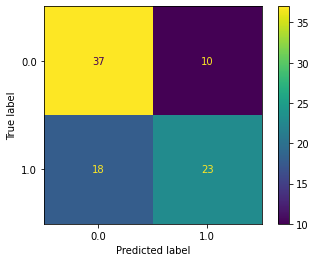


               precision    recall  f1-score   support

         0.0       0.67      0.79      0.73        47
         1.0       0.70      0.56      0.62        41

    accuracy                           0.68        88
   macro avg       0.68      0.67      0.67        88
weighted avg       0.68      0.68      0.68        88

ROC AUC: 70.78%


In [77]:
selecao_LR.roda_pipeline_metricas(random_state=2347)

### Utilizando Randon Forest

#### Testando
Como no anterior, começaremos de uma forma mais ampla até achar o modelo mais preciso.


In [21]:
# cria um objeto com a classe de seleção do modelo
selecao_RF = seleciona_modelo(RandomForestClassifier())
# seleção dos parâmetros de teste para este modelo
testes  = {'n_estimators': [10, 50, 100],
           'max_depth': [5, 10, 15],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
5,0.802252,0.047026,0.708199,0.896305,LE,StandardScaler(),1.0*mean,36,entropy,10,100
4,0.801628,0.044706,0.712216,0.891040,LE,nenhuma,1.0*mean,36,gini,5,100
1,0.807633,0.047073,0.713488,0.901778,LE,StandardScaler(),sem seleção adicional,91,gini,10,100
0,0.802023,0.041135,0.719752,0.884293,LE,nenhuma,sem seleção adicional,91,entropy,10,100
6,0.805663,0.040855,0.723953,0.887373,LE,nenhuma,1.5*mean,25,entropy,5,100


In [25]:
selecao_RF.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
15,0.783824,0.053591,0.676642,0.891005,OHE,StandardScaler(),1.5*mean,27,gini,5,100
12,0.795618,0.059089,0.677439,0.913797,OHE,nenhuma,1.0*mean,36,gini,10,100
11,0.794791,0.056037,0.682717,0.906865,OHE,StandardScaler(),0.5*mean,42,entropy,10,100
7,0.799768,0.055544,0.688680,0.910856,LE,StandardScaler(),1.5*mean,25,entropy,5,100
3,0.801960,0.055268,0.691423,0.912497,LE,StandardScaler(),0.5*mean,41,gini,5,100
14,0.782694,0.045294,0.692105,0.873282,OHE,nenhuma,1.5*mean,27,gini,5,100
8,0.796939,0.052228,0.692483,0.901395,OHE,nenhuma,sem seleção adicional,96,entropy,10,100
13,0.792443,0.046753,0.698938,0.885949,OHE,StandardScaler(),1.0*mean,36,gini,5,100
9,0.794636,0.046492,0.701652,0.887620,OHE,StandardScaler(),sem seleção adicional,96,entropy,10,100
10,0.798482,0.047377,0.703728,0.893236,OHE,nenhuma,0.5*mean,42,gini,5,100


Nesta primeira roda percebo que o StandardScaler não tem feito muita diferença e será desconsiderado na próxima rodada.

Também irei trabalhar melhor no max_depth, dado que o valor de 15 não tem gerado valor, irei rever o intevarlo para ver se obtenho resultados melhores com outros parametros.

Outro ponto que podemos perceber é que quanto mais estimators, melhor o resultado, como não pretendo aumentar mais este valor, já vou deixa-lo travado em 100.

Por fim, podemos observar que a base LE está trazendo resultados melhores, podemos fazer essa seleção da próxima vez.

In [30]:
testes  = {'n_estimators': [100],
           'max_depth': [4, 6, 8, 10],
           'criterion': ['gini','entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
2,0.798778,0.049545,0.699689,0.897867,LE,nenhuma,1.0*mean,34,gini,6,100
1,0.801608,0.048744,0.704120,0.899096,LE,nenhuma,0.5*mean,41,entropy,10,100
3,0.803816,0.044507,0.714803,0.892829,LE,nenhuma,1.5*mean,27,gini,6,100
0,0.807094,0.044266,0.718562,0.895626,LE,nenhuma,sem seleção adicional,91,entropy,6,100


Como os resultados estão muito próximos, vou aumentar o número de repetições para ter uma avaliação melhor do resultado e focar no intervalo de 6 a 10 no max_depth

In [34]:
testes  = {'n_estimators': [100],
           'max_depth': [6, 8, 10],
           'criterion': ['gini','entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            selecao_menor=-100, selecao_maior=50, passo=50, n_repeats=20)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
3,0.795657,0.046341,0.702975,0.888339,LE,nenhuma,1.5*mean,25,entropy,8,100
2,0.804904,0.049398,0.706108,0.903700,LE,nenhuma,1.0*mean,37,entropy,6,100
1,0.805796,0.046212,0.713372,0.898219,LE,nenhuma,0.5*mean,42,entropy,8,100
0,0.806028,0.046049,0.713931,0.898125,LE,nenhuma,sem seleção adicional,91,gini,8,100


Percebemos que o modelo está trabalhando melhor com mais registros, vamos ajustar o invervalo para ter mais opções nesse sentido

In [37]:
testes  = {'n_estimators': [100],
           'max_depth': [6, 8, 10],
           'criterion': ['gini','entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            selecao_menor=-100, selecao_maior=0, passo=20, n_repeats=20)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.19999999999999996*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.8*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
1,0.801551,0.050923,0.699704,0.903397,LE,nenhuma,0.19999999999999996*mean,47,gini,6,100
0,0.805147,0.050400,0.704346,0.905947,LE,nenhuma,sem seleção adicional,91,entropy,8,100
4,0.802440,0.047780,0.706880,0.898001,LE,nenhuma,0.8*mean,38,gini,6,100
2,0.803666,0.048183,0.707300,0.900032,LE,nenhuma,0.4*mean,41,gini,8,100
5,0.805108,0.044332,0.716444,0.893771,LE,nenhuma,1.0*mean,36,gini,10,100


vou fazer uma ultima tentativa aumento as repetições e revendo o intervalo para manter 2 modelos de seleção

In [44]:
testes  = {'n_estimators': [100],
           'max_depth': [6, 8, 10],
           'criterion': ['gini','entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            selecao_menor=-60, selecao_maior=0, passo=15, n_repeats=30)

Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.55*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.85*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
3,0.801090,0.052265,0.696561,0.905620,LE,nenhuma,0.85*mean,37,entropy,6,100
0,0.803126,0.046951,0.709224,0.897028,LE,nenhuma,0.4*mean,42,gini,10,100
4,0.802320,0.045665,0.710990,0.893650,LE,nenhuma,1.0*mean,38,gini,8,100
1,0.802465,0.044567,0.713332,0.891599,LE,nenhuma,0.55*mean,41,gini,10,100
2,0.802722,0.041242,0.720239,0.885206,LE,nenhuma,0.7*mean,39,gini,6,100


#### Criando o pipeline e observando as métricas
Após todos os testes, sendo o último com um grande número de repetições para retirar as incertezar, podemos criar o melhor pipeline com base no melhor resultado (ROC AUC médio: 0,803 com intervalo de confiança entre 0,720 até 0,885).

Também vamos visualizar quais foram as 39 variáveis seleciondas como base para o modelo

In [46]:
selecao_RF.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_RF.resultados.loc[selecao_RF.indice,'selecionador'].get_feature_names_out())

variávereis selecionadas:



['AGE_ABOVE65',
 'AGE_PERCENTIL',
 'BE_VENOUS_MEDIAN',
 'BIC_VENOUS_MEDIAN',
 'CALCIUM_MEDIAN',
 'CREATININ_MEDIAN',
 'FFA_MEDIAN',
 'GGT_MEDIAN',
 'GLUCOSE_MEDIAN',
 'HEMATOCRITE_MEDIAN',
 'INR_MEDIAN',
 'LACTATE_MEDIAN',
 'LEUKOCYTES_MEDIAN',
 'LINFOCITOS_MEDIAN',
 'PC02_VENOUS_MEDIAN',
 'PCR_MEDIAN',
 'PH_VENOUS_MEDIAN',
 'POTASSIUM_MEDIAN',
 'SAT02_VENOUS_MEDIAN',
 'SODIUM_MEDIAN',
 'TGO_MEDIAN',
 'UREA_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'RESPIRATORY_RATE_MEAN',
 'TEMPERATURE_MEAN',
 'OXYGEN_SATURATION_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MIN',
 'HEART_RATE_MIN',
 'OXYGEN_SATURATION_MIN',
 'BLOODPRESSURE_DIASTOLIC_MAX',
 'BLOODPRESSURE_SISTOLIC_MAX',
 'RESPIRATORY_RATE_MAX',
 'TEMPERATURE_MAX',
 'OXYGEN_SATURATION_MAX',
 'BLOODPRESSURE_DIASTOLIC_DIFF',
 'BLOODPRESSURE_SISTOLIC_DIFF',
 'HEART_RATE_DIFF',
 'RESPIRATORY_RATE_DIFF',
 'TEMPERATURE_DIFF']

Podemos também verificar o resultado desse modelo contra uma base de teste aleatória. Porém para comparação continuarei olhando o resultado anterior, olhando o limite inferior do intervalo de confiança.

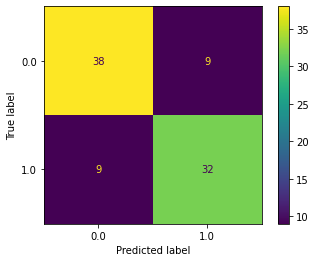


               precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        47
         1.0       0.78      0.78      0.78        41

    accuracy                           0.80        88
   macro avg       0.79      0.79      0.79        88
weighted avg       0.80      0.80      0.80        88

ROC AUC: 84.33%


In [57]:
selecao_RF.roda_pipeline_metricas(random_state=2347)

### Comparando os modelos e salvando o melhor
Para a janela de 0-2 horas vemos os dois modelos com resultados muito próximos, podemos dizer que temos um empate técnico, podendo seguir com a utilização de qualquer um deles.

Vou deixar ambos salvos e caso tenhamos uma diferença no intervalo seguinte podemos optar por seguir com apenas um deles. De qualquer maneira seria bom seguir comparando dada a proximidade do resultado.

In [84]:
selecao_LR.cria_salva_modelo_final('modelo_LR_0_2.joblib')

'modelo salvo como: modelo_LR_0_2.joblib'

In [85]:
selecao_RF.cria_salva_modelo_final('modelo_RF_0_2.joblib')

'modelo salvo como: modelo_RF_0_2.joblib'

## Encontrando o melhor pipeline para a janela de 2-4 horas

### Preparando a base para essa janela

In [27]:
# filtrando apenas a primeira janela de dados_LE
dados_LE_2_4 = adiciona_janela(dados_LE_0_2, dados_LE[dados_LE["WINDOW"] == '2-4'])
# filtrando apenas a primeira janela de dados_OHE utilizando outro forma de fazer isso
dados_OHE_2_4 = adiciona_janela(dados_OHE_0_2, dados_OHE.query("WINDOW == '2-4'"))


Removemos as colunas que os valores são iguais para todas as linhas

Base nova de tamanho: (325, 663)

Removemos as colunas que os valores são iguais para todas as linhas

Base nova de tamanho: (325, 672)


### Encontrando o melhor modelo de regressão logística

#### Testando

In [47]:
# cria um objeto com a classe de seleção do modelo
selecao_LR2 = seleciona_modelo(LogisticRegression(max_iter=6000))
# seleção dos parâmetros de teste para este modelo
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_LR2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
14,0.840135,0.049297,0.741541,0.938729,OHE,nenhuma,1.5*mean,60,newton-cg
10,0.823042,0.037645,0.747752,0.898332,OHE,nenhuma,0.5*mean,88,sag
6,0.842418,0.043103,0.756213,0.928624,LE,nenhuma,1.5*mean,58,lbfgs
4,0.839273,0.037985,0.763304,0.915243,LE,nenhuma,1.0*mean,72,newton-cg
12,0.834399,0.035353,0.763693,0.905105,OHE,nenhuma,1.0*mean,75,saga


In [48]:
selecao_LR2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
1,0.761575,0.051512,0.658552,0.864598,LE,StandardScaler(),sem seleção adicional,228,saga
9,0.755771,0.043614,0.668543,0.842998,OHE,StandardScaler(),sem seleção adicional,233,liblinear
3,0.784345,0.049275,0.685796,0.882895,LE,StandardScaler(),0.5*mean,81,saga
11,0.783177,0.048152,0.686874,0.879481,OHE,StandardScaler(),0.5*mean,88,liblinear
13,0.799908,0.051047,0.697814,0.902002,OHE,StandardScaler(),1.0*mean,75,sag
8,0.806286,0.051893,0.702499,0.910073,OHE,nenhuma,sem seleção adicional,233,newton-cg
5,0.803981,0.049309,0.705363,0.902600,LE,StandardScaler(),1.0*mean,72,newton-cg
7,0.813923,0.048808,0.716307,0.911539,LE,StandardScaler(),1.5*mean,58,saga
2,0.828309,0.054576,0.719156,0.937462,LE,nenhuma,0.5*mean,81,lbfgs
0,0.820757,0.047107,0.726542,0.914972,LE,nenhuma,sem seleção adicional,228,lbfgs


Olhando percebemos que novamente o StandardScaler()	piora o resultado, iremos retirar. Fora isso, precisamos rever o intervalo de seleção por ser evidente que a segunda seleção melhora a perfomance do modelo

In [49]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
selecao_LR2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            selecao_menor=-60, selecao_maior=60, passo=30)

Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
6,0.828050,0.043145,0.741760,0.914341,OHE,nenhuma,0.7*mean,82,newton-cg
1,0.829086,0.043425,0.742235,0.915936,LE,nenhuma,0.7*mean,79,newton-cg
0,0.827980,0.042627,0.742726,0.913234,LE,nenhuma,0.4*mean,89,newton-cg
8,0.841939,0.038164,0.765611,0.918266,OHE,nenhuma,1.3*mean,64,newton-cg
4,0.848797,0.039661,0.769474,0.928119,LE,nenhuma,1.6*mean,56,newton-cg


In [50]:
selecao_LR2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
7,0.826760,0.054952,0.716855,0.936664,OHE,nenhuma,1.0*mean,75,newton-cg
5,0.820627,0.048639,0.723350,0.917905,OHE,nenhuma,0.4*mean,93,newton-cg
2,0.835524,0.053442,0.728640,0.942409,LE,nenhuma,1.0*mean,72,sag
3,0.839806,0.050508,0.738789,0.940822,LE,nenhuma,1.3*mean,63,lbfgs
9,0.843717,0.051701,0.740315,0.947118,OHE,nenhuma,1.6*mean,59,newton-cg
6,0.828050,0.043145,0.741760,0.914341,OHE,nenhuma,0.7*mean,82,newton-cg
1,0.829086,0.043425,0.742235,0.915936,LE,nenhuma,0.7*mean,79,newton-cg
0,0.827980,0.042627,0.742726,0.913234,LE,nenhuma,0.4*mean,89,newton-cg
8,0.841939,0.038164,0.765611,0.918266,OHE,nenhuma,1.3*mean,64,newton-cg
4,0.848797,0.039661,0.769474,0.928119,LE,nenhuma,1.6*mean,56,newton-cg


Como estamos tendo muia oscilação no número vou aumentar no número de repetições. 

Fora isso, os maiores valores médios do ROC AUC são no intevarlo da média para cima, farei esse ajuste

In [52]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
selecao_LR2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            selecao_menor=0, selecao_maior=100, passo=20, n_repeats=20)

Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.2*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.2*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
2,0.842914,0.043205,0.756504,0.929325,LE,nenhuma,1.4*mean,61,lbfgs
0,0.837767,0.040380,0.757006,0.918527,LE,nenhuma,1.0*mean,72,newton-cg
10,0.843828,0.042584,0.758660,0.928996,OHE,nenhuma,1.8*mean,53,lbfgs
8,0.838238,0.038556,0.761125,0.915350,OHE,nenhuma,1.4*mean,62,sag
11,0.848511,0.036901,0.774709,0.922313,OHE,nenhuma,2.0*mean,47,newton-cg


In [54]:
selecao_LR2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
5,0.818500,0.050004,0.718493,0.918507,LE,nenhuma,2.0*mean,46,newton-cg
6,0.830463,0.049127,0.732209,0.928717,OHE,nenhuma,1.0*mean,74,lbfgs
4,0.832022,0.041260,0.749502,0.914543,LE,nenhuma,1.8*mean,52,newton-cg
9,0.841610,0.045312,0.750985,0.932235,OHE,nenhuma,1.6*mean,59,newton-cg
1,0.839702,0.044002,0.751697,0.927707,LE,nenhuma,1.2*mean,67,newton-cg
3,0.843468,0.045316,0.752835,0.934100,LE,nenhuma,1.6*mean,56,newton-cg
7,0.837892,0.041808,0.754276,0.921508,OHE,nenhuma,1.2*mean,67,sag
2,0.842914,0.043205,0.756504,0.929325,LE,nenhuma,1.4*mean,61,lbfgs
0,0.837767,0.040380,0.757006,0.918527,LE,nenhuma,1.0*mean,72,newton-cg
10,0.843828,0.042584,0.758660,0.928996,OHE,nenhuma,1.8*mean,53,lbfgs


Percebo que intervalo deveria rodar mais próximo do 1.5*mean, irei ajustar isso e já deixar apenas com os modelos newton-cg e lbfgs definidos por terem os melhores resultados

In [55]:
testes  = {'solver': ['newton-cg','lbfgs']} 
selecao_LR2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            selecao_menor=35, selecao_maior=75, passo=5, n_repeats=20)

Finalizada iteração: seleção - 1.35*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.45*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.65*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.75*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.35*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.45*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
5,0.845143,0.042197,0.760749,0.929538,LE,nenhuma,1.6*mean,56,lbfgs
2,0.843332,0.040708,0.761915,0.924749,LE,nenhuma,1.45*mean,59,newton-cg
9,0.838044,0.036622,0.764799,0.911289,OHE,nenhuma,1.35*mean,63,newton-cg
6,0.839739,0.036128,0.767484,0.911994,LE,nenhuma,1.65*mean,54,newton-cg
17,0.846158,0.037072,0.772014,0.920301,OHE,nenhuma,1.75*mean,55,newton-cg


In [56]:
selecao_LR2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
8,0.834632,0.053923,0.726786,0.942477,LE,nenhuma,1.75*mean,52,lbfgs
11,0.839117,0.050373,0.738372,0.939863,OHE,nenhuma,1.45*mean,61,newton-cg
7,0.838252,0.047773,0.742705,0.933799,LE,nenhuma,1.7*mean,52,lbfgs
13,0.839085,0.045794,0.747497,0.930674,OHE,nenhuma,1.55*mean,59,lbfgs
14,0.841401,0.046765,0.747871,0.934931,OHE,nenhuma,1.6*mean,59,newton-cg
3,0.844489,0.047954,0.748580,0.940397,LE,nenhuma,1.5*mean,58,newton-cg
0,0.841343,0.044873,0.751598,0.931088,LE,nenhuma,1.35*mean,61,newton-cg
15,0.841173,0.044677,0.751819,0.930527,OHE,nenhuma,1.65*mean,59,newton-cg
4,0.841350,0.042576,0.756198,0.926501,LE,nenhuma,1.55*mean,58,lbfgs
16,0.844945,0.044151,0.756642,0.933247,OHE,nenhuma,1.7*mean,57,newton-cg


fareri um último teste aumentando as repetições e restringindo o solver para 'newton-cg'

In [60]:
testes  = {'solver': ['newton-cg']} 
a = selecao_LR2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            selecao_menor=35, selecao_maior=75, passo=5, n_repeats=30)
selecao_LR2.classifica_resultados().tail(10)

Finalizada iteração: seleção - 1.35*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.45*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.65*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.75*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.35*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.45*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
7,0.835178,0.040691,0.753797,0.916560,LE,nenhuma,1.7*mean,52,newton-cg
10,0.841456,0.043514,0.754428,0.928483,OHE,nenhuma,1.4*mean,62,newton-cg
6,0.838988,0.041813,0.755363,0.922613,LE,nenhuma,1.65*mean,54,newton-cg
13,0.840363,0.042438,0.755487,0.925240,OHE,nenhuma,1.55*mean,59,newton-cg
5,0.843890,0.042964,0.757962,0.929818,LE,nenhuma,1.6*mean,56,newton-cg
16,0.843721,0.042091,0.759540,0.927902,OHE,nenhuma,1.7*mean,57,newton-cg
12,0.841288,0.039815,0.761657,0.920918,OHE,nenhuma,1.5*mean,60,newton-cg
1,0.843270,0.040730,0.761810,0.924729,LE,nenhuma,1.4*mean,61,newton-cg
3,0.845277,0.040034,0.765209,0.925346,LE,nenhuma,1.5*mean,58,newton-cg
17,0.845644,0.039868,0.765908,0.925380,OHE,nenhuma,1.75*mean,55,newton-cg


#### Criando o pipeline e observando as métricas
Após todos os testes, sendo o último com um grande número de repetições para retirar as incertezar, podemos criar o melhor pipeline com base no melhor resultado (ROC AUC médio: 0,846 com intervalo de confiança entre 0,766 até 0,925).

Também vamos visualizar quais foram as 55 variáveis seleciondas como base para o modelo

In [61]:
selecao_LR2.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_LR2.resultados.loc[selecao_LR2.indice,'selecionador'].get_feature_names_out())

variávereis selecionadas:



['GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 4',
 'HTN',
 'OTHER',
 'BIC_VENOUS_MEDIAN',
 'BLAST_MEDIAN',
 'CALCIUM_MEDIAN',
 'CREATININ_MEDIAN',
 'GLUCOSE_MEDIAN',
 'LEUKOCYTES_MEDIAN',
 'LINFOCITOS_MEDIAN',
 'P02_ARTERIAL_MEDIAN',
 'PCR_MEDIAN',
 'POTASSIUM_MEDIAN',
 'SAT02_VENOUS_MEDIAN',
 'SODIUM_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'TEMPERATURE_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MIN',
 'BLOODPRESSURE_SISTOLIC_MAX',
 'BLOODPRESSURE_DIASTOLIC_DIFF',
 'HEART_RATE_DIFF',
 'TEMPERATURE_DIFF',
 '10th',
 '80th',
 '90th',
 'Above 90th',
 'BIC_VENOUS_MEDIAN 0-2',
 'CALCIUM_MEDIAN 0-2',
 'GLUCOSE_MEDIAN 0-2',
 'LEUKOCYTES_MEDIAN 0-2',
 'P02_ARTERIAL_MEDIAN 0-2',
 'PCR_MEDIAN 0-2',
 'POTASSIUM_MEDIAN 0-2',
 'SODIUM_MEDIAN 0-2',
 'BLOODPRESSURE_DIASTOLIC_MEAN 0-2',
 'BLOODPRESSURE_DIASTOLIC_MIN 0-2',
 'BLOODPRESSURE_SISTOLIC_MAX 0-2',
 'BLOODPRESSURE_SISTOLIC_DIFF 0-2',
 'HEART_RATE_DIFF 0-2',
 'var ALBUMIN_MEDIAN 0-2',
 'var GGT_MEDIAN 0-2',
 'var HEMATOCRITE_MEDIAN 0-2',
 'var L


Podemos também verificar o resultado desse modelo contra uma base de teste aleatória. Porém para comparação continuarei olhando o resultado anterior, olhando o limite inferior do intervalo de confiança.

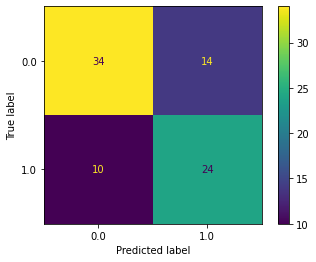


               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74        48
         1.0       0.63      0.71      0.67        34

    accuracy                           0.71        82
   macro avg       0.70      0.71      0.70        82
weighted avg       0.71      0.71      0.71        82

ROC AUC: 77.14%


In [62]:
selecao_LR2.roda_pipeline_metricas(random_state=2347)

### Encontrando o melhor modelo de Random Forest

#### Testando

In [45]:
# cria um objeto com a classe de seleção do modelo
selecao_RF2 = seleciona_modelo(RandomForestClassifier())
# seleção dos parâmetros de teste para este modelo
testes  = {'n_estimators': [10, 50, 100],
           'max_depth': [5, 10, 15],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
9,0.857267,0.036539,0.784189,0.930344,OHE,StandardScaler(),sem seleção adicional,233,gini,5,100
2,0.857243,0.035693,0.785858,0.928629,LE,nenhuma,0.5*mean,92,entropy,5,100
1,0.863264,0.036098,0.791069,0.935460,LE,StandardScaler(),sem seleção adicional,228,entropy,5,100
7,0.869027,0.038494,0.792038,0.946015,LE,StandardScaler(),1.5*mean,58,entropy,5,100
6,0.865589,0.029859,0.805872,0.925306,LE,nenhuma,1.5*mean,58,entropy,5,100


In [53]:
selecao_RF2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
5,0.856183,0.050835,0.754512,0.957853,LE,StandardScaler(),1.0*mean,75,gini,5,100
12,0.852030,0.045085,0.761861,0.942200,OHE,nenhuma,1.0*mean,81,gini,5,100
10,0.853041,0.044801,0.763438,0.942644,OHE,nenhuma,0.5*mean,94,entropy,5,100
15,0.857649,0.044203,0.769242,0.946055,OHE,StandardScaler(),1.5*mean,62,entropy,10,100
3,0.857690,0.044133,0.769424,0.945956,LE,StandardScaler(),0.5*mean,92,entropy,5,100
4,0.862316,0.045114,0.772088,0.952545,LE,nenhuma,1.0*mean,75,entropy,5,100
13,0.852144,0.038674,0.774796,0.929491,OHE,StandardScaler(),1.0*mean,81,entropy,5,100
0,0.863101,0.041714,0.779673,0.946528,LE,nenhuma,sem seleção adicional,228,entropy,5,100
11,0.852872,0.036128,0.780615,0.925128,OHE,StandardScaler(),0.5*mean,94,entropy,5,100
8,0.859903,0.039458,0.780987,0.938820,OHE,nenhuma,sem seleção adicional,233,entropy,10,100


Podemos já replicar alguns ajustes feitos para a outra janela, como o n_estimators, max_depth e base ser a LE

In [59]:
testes  = {'n_estimators': [100],
           'max_depth': [4,6,8,10],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
6,0.864369,0.044530,0.775310,0.953428,LE,nenhuma,1.5*mean,62,entropy,6,100
3,0.863032,0.043581,0.775869,0.950195,LE,StandardScaler(),0.5*mean,90,entropy,4,100
4,0.858574,0.040296,0.777982,0.939166,LE,nenhuma,1.0*mean,76,entropy,4,100
7,0.861252,0.038697,0.783859,0.938646,LE,StandardScaler(),1.5*mean,62,entropy,4,100
1,0.860457,0.037669,0.785118,0.935795,LE,StandardScaler(),sem seleção adicional,228,entropy,6,100


In [63]:
selecao_RF2.classifica_resultados().head(10)

,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
2,0.859076,0.048090,0.762895,0.955257,LE,nenhuma,0.5*mean,90,gini,6,100
5,0.862431,0.049136,0.764159,0.960703,LE,StandardScaler(),1.0*mean,76,entropy,8,100
0,0.860889,0.045388,0.770113,0.951665,LE,nenhuma,sem seleção adicional,228,entropy,6,100
6,0.864369,0.044530,0.775310,0.953428,LE,nenhuma,1.5*mean,62,entropy,6,100
3,0.863032,0.043581,0.775869,0.950195,LE,StandardScaler(),0.5*mean,90,entropy,4,100
4,0.858574,0.040296,0.777982,0.939166,LE,nenhuma,1.0*mean,76,entropy,4,100
7,0.861252,0.038697,0.783859,0.938646,LE,StandardScaler(),1.5*mean,62,entropy,4,100
1,0.860457,0.037669,0.785118,0.935795,LE,StandardScaler(),sem seleção adicional,228,entropy,6,100


Vemos uma predominancia do criterio 'entropy', então iremos manter apenas ele.

Fora isso o StandardScaler() parece ter um resultado melhor, então irei manter apenas ele. 

Por fim, irei aumentar as repetições dada as grandes oscilações

In [68]:
testes  = {'n_estimators': [100],
           'max_depth': [4,6,8,10],
           'criterion': ['entropy']}
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE')], lista_reescalas=[StandardScaler()],
                             selecao_menor=-100, selecao_maior=50, passo=50, n_repeats=20)

Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
1,0.857063,0.044716,0.767630,0.946496,LE,StandardScaler(),0.5*mean,89,entropy,6,100
0,0.859356,0.041589,0.776177,0.942535,LE,StandardScaler(),sem seleção adicional,228,entropy,6,100
3,0.860487,0.038577,0.783332,0.937641,LE,StandardScaler(),1.5*mean,58,entropy,6,100
2,0.862835,0.037553,0.787730,0.937941,LE,StandardScaler(),1.0*mean,74,entropy,6,100


Conseguimos observar agora uma melhora quando temos um segundo seletor, rodando perto da média. 

Vamos fazer mais um teste aumentando as repetições e deixando o intervalo mais próximo da média

In [93]:
testes  = {'n_estimators': [100],
           'max_depth': [4,6,8],
           'criterion': ['entropy']}
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE')], lista_reescalas=[StandardScaler()],
                             selecao_menor=-20, selecao_maior=60, passo=20, n_repeats=30)

Finalizada iteração: seleção - 0.8*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.2*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.4*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - StandardScaler(), base - LE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
0,0.858726,0.044173,0.770380,0.947072,LE,StandardScaler(),0.8*mean,85,entropy,6,100
2,0.860820,0.040929,0.778963,0.942678,LE,StandardScaler(),1.2*mean,66,entropy,6,100
4,0.859812,0.039025,0.781762,0.937862,LE,StandardScaler(),1.6*mean,58,entropy,6,100
1,0.860901,0.037201,0.786498,0.935304,LE,StandardScaler(),1.0*mean,75,entropy,6,100
3,0.865006,0.037156,0.790694,0.939318,LE,StandardScaler(),1.4*mean,61,entropy,6,100


#### Criando o pipeline e observando as métricas
Após todos os testes, sendo o último com um grande número de repetições para retirar as incertezar, podemos criar o melhor pipeline com base no melhor resultado (ROC AUC médio: 0,865 com intervalo de confiança entre 0,791 até 0,939).

Também vamos visualizar quais foram as 61 variáveis seleciondas como base para o modelo

In [94]:
selecao_RF2.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_RF2.resultados.loc[selecao_RF2.indice,'selecionador'].get_feature_names_out())

variávereis selecionadas:



['AGE_ABOVE65',
 'AGE_PERCENTIL',
 'CALCIUM_MEDIAN',
 'CREATININ_MEDIAN',
 'GLUCOSE_MEDIAN',
 'INR_MEDIAN',
 'LEUKOCYTES_MEDIAN',
 'LINFOCITOS_MEDIAN',
 'PC02_VENOUS_MEDIAN',
 'PCR_MEDIAN',
 'PLATELETS_MEDIAN',
 'POTASSIUM_MEDIAN',
 'SODIUM_MEDIAN',
 'TGO_MEDIAN',
 'UREA_MEDIAN',
 'DIMER_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'RESPIRATORY_RATE_MEAN',
 'TEMPERATURE_MEAN',
 'OXYGEN_SATURATION_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MIN',
 'HEART_RATE_MIN',
 'OXYGEN_SATURATION_MIN',
 'BLOODPRESSURE_DIASTOLIC_MAX',
 'BLOODPRESSURE_SISTOLIC_MAX',
 'RESPIRATORY_RATE_MAX',
 'TEMPERATURE_MAX',
 'BLOODPRESSURE_DIASTOLIC_DIFF',
 'HEART_RATE_DIFF',
 'GGT_MEDIAN 0-2',
 'GLUCOSE_MEDIAN 0-2',
 'HEMATOCRITE_MEDIAN 0-2',
 'LEUKOCYTES_MEDIAN 0-2',
 'LINFOCITOS_MEDIAN 0-2',
 'PC02_VENOUS_MEDIAN 0-2',
 'PCR_MEDIAN 0-2',
 'POTASSIUM_MEDIAN 0-2',
 'SODIUM_MEDIAN 0-2',
 'UREA_MEDIAN 0-2',
 'BLOODPRESSURE_DIASTOLIC_MEAN 0-2',
 'HEART_RATE_MEAN 0-2',
 'RESPIRATORY_RATE_MEAN 0-2',
 'TEMPERATURE_MEAN 0-2',
 'OXYGE

Podemos também verificar o resultado desse modelo contra uma base de teste aleatória. Porém para comparação continuarei olhando o resultado anterior, olhando o limite inferior do intervalo de confiança.

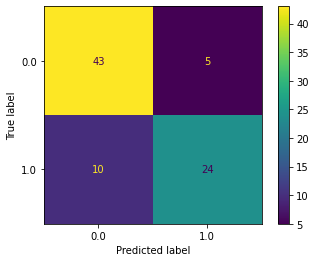


               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        48
         1.0       0.83      0.71      0.76        34

    accuracy                           0.82        82
   macro avg       0.82      0.80      0.81        82
weighted avg       0.82      0.82      0.81        82

ROC AUC: 86.52%


In [95]:
selecao_RF2.roda_pipeline_metricas(random_state=2347)

In [88]:
selecao_RF2.pipe

Pipeline(steps=[('seletor1', remove_corr()),
                ('seletor2',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='0.8*mean')),
                ('reescala',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='0.8*mean')),
                ('modelo',
                 RandomForestClassifier(criterion='entropy', max_depth=6))])

### Comparando os modelos e salvando o melhor
Para a janela de 2-4 horas vemos o modelo Random Forest um pouco a frente, com resultados um pouco melhores e consequentemente deixaremos apenas este modelo salvo para está janela.


In [96]:
selecao_RF2.cria_salva_modelo_final('modelo_RF_2_4.joblib')

'modelo salvo como: modelo_RF_2_4.joblib'

## Conclusão
Como esperado quando vamos para a janela seguinte, tendo mais informações conseguimos ter modelos preditivos melhores. Imagino que o mesmo efeito irá acontecer se formos para a próxima janela, caberia o teste.

Um ponto interessante é que ambos os modelos funcionam melhor com uma menor quantidade de variáveis, tanto que melhorou quando fizemos duas seleções sequenciais em cima dos dados.

Por fim, o modelo Random Forest demonstrou ser melhor para a solução deste problema, apesar que o Logistic Regression não ficou muito para trás.

Caberia avaliar outros modelos futuramente.

